# TT1 - MDM UBA - 2025

**Tariff classification using NLP**

By Santiago Tedoldi

## Fine-tuned & Error analysis

In [115]:
import os
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.decomposition import PCA

### Fine-tuned model viz

Model classes and embedding function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertModel

class TokenizedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }
    
class HSClassifier(nn.Module):
    def __init__(self,
                 n_classes: int,
                 fine_tune: bool = False,
                 n_finetune_layers: int = 0):
        """
        Args:
          n_classes:      number of target classes
          fine_tune:      if True, you’ll unfreeze either all or the last layers
          n_finetune_layers:
                          • =0 (default) → if fine_tune=True, unfreeze *all* DistilBERT layers  
                          • >0             → unfreeze only that many of the *last* transformer blocks  
                          • ignored if fine_tune=False (encoder stays fully frozen)
        """
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained("distilbert-base-uncased")

        # Freeze everything by default
        for param in self.distilbert.parameters():
            param.requires_grad = False

        # If fine_tune, decide what to unfreeze
        if fine_tune:
            if n_finetune_layers > 0:
                # Unfreeze only the last `n_finetune_layers` transformer blocks
                for block in self.distilbert.transformer.layer[-n_finetune_layers:]:
                    for param in block.parameters():
                        param.requires_grad = True
            else:
                # n_finetune_layers == 0 → unfreeze *all* DistilBERT params
                for param in self.distilbert.parameters():
                    param.requires_grad = True

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(self.distilbert.config.hidden_size, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.3),
            nn.Linear(1024, n_classes),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs.last_hidden_state[:, 0, :]  # Take <CLS> token representation
        logits = self.classifier(hidden_state)
        return logits
    
class HSDataset(Dataset):
    def __init__(self, dataframe, tokenizer, desc_col='', label_col='', max_length=500):
        self.descriptions = dataframe[desc_col].tolist()
        self.labels = dataframe[label_col].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.descriptions[idx],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': self.labels[idx],
            'description': self.descriptions[idx]
        }
        return item
    
# Function to extract [CLS] embeddings
def get_embeddings(dataloader, model, device):
    all_embeds = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attn = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn)
            # DistilBERT does not have pooler; use first token hidden state
            cls_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeds.append(cls_embeds)
            all_labels.extend(batch['label'])
    return np.vstack(all_embeds), np.array(all_labels)
    

Viz function with PCA

In [21]:
def pca_viz_embs(embeds, labels, n_componets=2, title='',
                 legend_title='', html_output_file=''):

    pca = PCA(n_components=n_componets)
    emb = pca.fit_transform(embeds)

    fig = go.Figure()
    for chap in np.unique(labels):
        mask = labels == chap
        if n_componets==2:
            fig.add_trace(go.Scatter(
                x=emb[mask, 0],
                y=emb[mask, 1],
                mode='markers',
                name=chap,
                marker=dict(size=4),
                hovertext=[chap]*mask.sum(),
                hoverinfo='text'
            ))
        elif n_componets==3:
            fig.add_trace(go.Scatter3d(
                x=emb[mask, 0],
                y=emb[mask, 1],
                z=emb[mask, 2],
                mode='markers',
                name=chap,
                marker=dict(size=3),
                hovertext=[chap]*mask.sum(),
                hoverinfo='text'
            ))
        else:
            return 
    if n_componets==2:
        scene = dict(
            xaxis_title="PC1", yaxis_title="PC2")
    elif n_componets==3:
        scene = dict(
            xaxis_title="PC1", yaxis_title="PC2", zaxis_title="PC3")
    else:
        return 
    fig.update_layout(
        title=title,
        scene=scene,
        legend_title=legend_title,
        width=1200, height=900
    )
    fig.write_html(html_output_file)
    print(f"📄 Saved plot to {html_output_file}")

Loading finetuned model

In [12]:
# reading labels
with open('models/labels_dict.json', 'r') as f:
    labels_dict = json.load(f)

label2id = labels_dict['label2id']
id2label = labels_dict['id2label']

# loading tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# loading model
model_name = 'distiltbert_hs04_simple_classifier_finetuned_3epochs_13062025_150328.pth'

model_save_path = os.path.join('models', model_name)

model_finetuned = HSClassifier(n_classes=len(label2id), fine_tune=True)

model_finetuned.load_state_dict(torch.load(model_save_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_finetuned.to(device)

model_finetuned.eval() # to set the model for inference

C:\Users\santt\AppData\Local\Temp\ipykernel_29228\1868374554.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_finetuned.load_state_dict(torch.load(model_save_path)

Using device: cuda


HSClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

Getting embeddings from full finetune test

In [62]:
# Reading the dataset
results_finetuned = pd.read_csv('results/hs04_distiltbert_finetuned_results.csv', index_col=0)

# Getting chapter labels for viz
results_finetuned['True Chapter'] = results_finetuned['True Label'].astype(str).str[:2]

# Build dataset and loader - sampled for viz comparison with EDA
ds = HSDataset(results_finetuned.sample(len(results_finetuned)//2), 
               tokenizer, desc_col='Description', 
               label_col='True Chapter', max_length=300)

loader = DataLoader(ds, batch_size=32, shuffle=False)

embeds_finetuned, labels_finetuned = get_embeddings(loader, model_finetuned.distilbert, device)
print("Embeddings shape:", embeds_finetuned.shape)

Embeddings shape: (13389, 768)


In [64]:
labels_finetuned

array(['87', '22', '84', ..., '85', '94', '85'], dtype='<U2')

Viz Good Description embedding

In [ ]:
pca_viz_embs(embeds_finetuned, labels_finetuned, n_componets=2,
             title="Goods Description - 2D PCA of DistilBERT Finetuned Embeddings",
             legend_title="HS02 Chapter",
             html_output_file="embeddings_2d_goods_desc_finetuned.html")

📄 Saved plot to embeddings_2d_goods_desc_finetuned.html


In [ ]:
pca_viz_embs(embeds_finetuned, labels_finetuned, n_componets=3,
             title="Goods Description - 3D PCA of DistilBERT Finetuned Embeddings",
             legend_title="HS02 Chapter",
             html_output_file="embeddings_3d_goods_desc_finetuned.html")

📄 Saved plot to embeddings_3d_goods_desc_finetuned.html


Viz embs from full_eng nomenclature

In [63]:
df_hs06 = pd.read_csv('data/hs06_full_eng.csv', index_col='hs06', 
                      dtype={'hs06': str, 'full_eng': str},
                      usecols=['hs06', 'full_eng'])

# Getting chapter labels for viz
df_hs06['HS02'] = df_hs06.index.astype(str).str[:2]

# Build dataset and loader - sampled for viz comparison with EDA
ds = HSDataset(df_hs06, 
               tokenizer, desc_col='full_eng', 
               label_col='HS02', max_length=300)

loader = DataLoader(ds, batch_size=32, shuffle=False)

embeds_full_eng, labels_full_eng = get_embeddings(loader, model_finetuned.distilbert, device)
print("Embeddings shape:", embeds_full_eng.shape)

Embeddings shape: (6064, 768)


In [65]:
labels_full_eng

array(['01', '01', '01', ..., '96', '97', '97'], dtype='<U2')

In [ ]:
pca_viz_embs(embeds_full_eng, labels_full_eng, n_componets=3,
             title="HS06 full eng - 3D PCA of DistilBERT Finetuned Embeddings",
             legend_title="HS02 Chapter",
             html_output_file="embeddings_3d_hs06_full_eng_finetuned.html")

📄 Saved plot to embeddings_3d_hs06_full_eng_finetuned.html


### Error analysis

In [70]:
dtypes = {'Description': str, 
          'True Label': str,
          'Top1': str,
          'Top2': str,
          'Top3': str,
          'Top4': str,
          'Top5': str,
          }

results_finetuned2 = pd.read_csv('results/hs04_distiltbert_finetuned_2layers_results.csv',
                                  index_col=0, dtype=dtypes)
results_finetuned = pd.read_csv('results/hs04_distiltbert_finetuned_results.csv',
                                index_col=0, dtype=dtypes)

In [68]:
torch.cuda.empty_cache()

Loading models

In [69]:
# reading labels
with open('models/labels_dict.json', 'r') as f:
    labels_dict = json.load(f)

label2id = labels_dict['label2id']
id2label = labels_dict['id2label']

# loading tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# finetuned 2layers model
# loading model
model_name = 'distiltbert_hs04_simple_classifier_finetuned_2layers_6epochs_14062025_003324.pth'

model_save_path = os.path.join('models', model_name)

model_finetuned2 = HSClassifier(n_classes=len(label2id), fine_tune=True)

model_finetuned2.load_state_dict(torch.load(model_save_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_finetuned2.to(device)

model_finetuned2.eval() # to set the model for inference

# finetuned model

# loading model
model_name = 'distiltbert_hs04_simple_classifier_finetuned_3epochs_13062025_150328.pth'

model_save_path = os.path.join('models', model_name)

model_finetuned = HSClassifier(n_classes=len(label2id), fine_tune=True)

model_finetuned.load_state_dict(torch.load(model_save_path))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model_finetuned.to(device)

model_finetuned.eval() # to set the model for inference

C:\Users\santt\AppData\Local\Temp\ipykernel_29228\2281049692.py:19: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Using device: cuda


C:\Users\santt\AppData\Local\Temp\ipykernel_29228\2281049692.py:36: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Using device: cuda


HSClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

Getting test embeddings

In [72]:
# results_finetuned2
ds = HSDataset(results_finetuned2, 
               tokenizer, desc_col='Description', 
               label_col='True Label', max_length=300)

loader2 = DataLoader(ds, batch_size=128, shuffle=False)

embeds_finetuned2, labels_finetuned2 = get_embeddings(loader2, model_finetuned2.distilbert, device)
print("Embeddings shape:", embeds_finetuned2.shape)

Embeddings shape: (26778, 768)


In [73]:
# results_finetuned
ds = HSDataset(results_finetuned, 
               tokenizer, desc_col='Description', 
               label_col='True Label', max_length=300)

loader = DataLoader(ds, batch_size=128, shuffle=False)

embeds_finetuned, labels_finetuned = get_embeddings(loader, model_finetuned.distilbert, device)
print("Embeddings shape:", embeds_finetuned.shape)

Embeddings shape: (26778, 768)


Merging with HS06 nomenclature

In [ ]:
df_hs06 = pd.read_csv('data/hs06_full_eng.csv', index_col='hs06', 
                      dtype={'hs06': str, 'full_eng': str},
                      usecols=['hs06', 'full_eng'])

# Getting chapter labels for viz
df_hs06.index = df_hs06.index.astype(str).str[:4]

results_finetuned2 = pd.merge(results_finetuned2, df_hs06, how='left', left_on='True Label', right_index=True)
results_finetuned = pd.merge(results_finetuned, df_hs06, how='left', left_on='True Label', right_index=True)

Cosine similarity between description and full eng nomenclature

In [83]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Map HS04 code → corresponding legal text embedding
hs04_to_hsvec = {}
for hs_code, emb in zip(df_hs06.index.str[:4], embeds_full_eng):
    hs04_to_hsvec[str(hs_code)] = emb

In [85]:
# results_finetuned2
cosine_sims = []

for i in range(len(embeds_finetuned2)):
    hs_code = str(labels_finetuned2[i])  # ensure string matching
    gd_vec = embeds_finetuned2[i].reshape(1, -1)  # shape (1, dim)

    hs_vec = hs04_to_hsvec.get(hs_code)

    if hs_vec is not None:
        hs_vec = hs_vec.reshape(1, -1)
        sim = cosine_similarity(gd_vec, hs_vec)[0][0]
    else:
        sim = np.nan  # if no match found, assign NaN

    cosine_sims.append(sim)

results_finetuned2['cosine_sim_desc_vs_hs_text'] = cosine_sims

In [89]:
results_finetuned2.head()

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5,cosine_sim_desc_vs_hs_text
3914,BEVEL GEAR (43A0002),8483,8483,0.867107,8708,0.046992,8448,0.036971,8422,0.008359,8714,0.006879,0.442531
143735,NANO FACIAL STEAMER,8516,8516,0.969369,9503,0.007005,7323,0.002286,3924,0.001876,8510,0.001727,0.183044
257095,DISINFECTION CABINET (KITCHEN UTENSIL),9403,9403,0.251126,3924,0.134935,7323,0.119689,8418,0.077727,7324,0.031028,0.314740
238825,USED TOYOTA WISH 2010,8703,8703,0.995775,8702,0.002103,8704,0.001041,8711,0.000131,7007,0.000016,0.299688
91527,RECORDER,8519,8519,0.556769,8521,0.234013,9207,0.053891,9202,0.035333,9209,0.015599,0.436766


In [87]:
# results_finetuned
cosine_sims = []

for i in range(len(embeds_finetuned)):
    hs_code = str(labels_finetuned2[i])  # ensure string matching
    gd_vec = embeds_finetuned[i].reshape(1, -1)  # shape (1, dim)

    hs_vec = hs04_to_hsvec.get(hs_code)

    if hs_vec is not None:
        hs_vec = hs_vec.reshape(1, -1)
        sim = cosine_similarity(gd_vec, hs_vec)[0][0]
    else:
        sim = np.nan  # if no match found, assign NaN

    cosine_sims.append(sim)

results_finetuned['cosine_sim_desc_vs_hs_text'] = cosine_sims

In [88]:
results_finetuned.head()

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,Top5,Proba Top5,cosine_sim_desc_vs_hs_text
3914,BEVEL GEAR (43A0002),8483,8483,0.891349,8708,0.054235,8431,0.013001,8482,0.009579,8448,0.004437,0.834508
143735,NANO FACIAL STEAMER,8516,8516,0.521912,8419,0.079620,7323,0.061562,3304,0.027125,3924,0.017655,0.527107
257095,DISINFECTION CABINET (KITCHEN UTENSIL),9403,7323,0.259573,9403,0.203982,3924,0.144587,8418,0.078116,7615,0.060856,0.637726
238825,USED TOYOTA WISH 2010,8703,8703,0.999423,8702,0.000097,8704,0.000054,8711,0.000053,8701,0.000004,0.592617
91527,RECORDER,8519,8519,0.647193,8521,0.215078,8527,0.050980,9202,0.015427,9209,0.013578,0.765251


More feature engineering

In [95]:
def create_proba_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a DataFrame with columns
      ['Description', 'True Label',
       'Top1', 'Proba Top1', 'Top2', 'Proba Top2', …, 'Top5', 'Proba Top5',
       'cosine_sim_desc_vs_hs_text'],
    this function:
      1) Ignores the 'TopN' category columns
      2) Finds the five probability columns
      3) Computes:
         - prob_mean
         - prob_max
         - prob_min
         - prob_range (max - min)
         - prob_std
         - all pairwise differences prob_i - prob_j for i<j
      4) Leaves cosine_sim_desc_vs_hs_text in place
      5) Returns a new DataFrame with these additional feature columns.
    """
    # Identify the probability columns automatically
    prob_cols = [c for c in df.columns if c.startswith("Proba Top")]
    if len(prob_cols) != 5:
        raise ValueError(f"Expected 5 Proba TopN columns, found: {prob_cols!r}")
    
    probs = df[prob_cols]
    
    # summary statistics
    df = df.copy()
    df['prob_mean']  = probs.mean(axis=1)
    df['prob_max']   = probs.max(axis=1)
    df['prob_min']   = probs.min(axis=1)
    df['prob_range'] = df['prob_max'] - df['prob_min']
    df['prob_std']   = probs.std(axis=1)
    
    # pairwise differences: Proba Top1 - Proba Top2, Proba Top1 - Proba Top3, ..., Proba Top4 - Proba Top5
    for i, j in itertools.combinations(range(1, 6), 2):
        ci = f"Proba Top{i}"
        cj = f"Proba Top{j}"
        df[f'prob_diff_{i}_{j}'] = df[ci] - df[cj]
    
    # (cosine_sim_desc_vs_hs_text is already in df; if you want to rename:)
    # df = df.rename(columns={
    #                         'Proba Top1': 'prob_top1',
    #                         'Proba Top2': 'prob_top2',
    #                         'Proba Top3': 'prob_top3',
    #                         'Proba Top4': 'prob_top4',
    #                         'Proba Top5': 'prob_top5',
    #                         'True Label': 'true_label',
    #                         'cosine_sim_desc_vs_hs_text': 'cosine_sim'
    #                         })
    
    return df

In [99]:
results_finetuned2 = create_proba_features(results_finetuned2)
results_finetuned = create_proba_features(results_finetuned)

In [100]:
results_finetuned2.columns

Index(['Description', 'True Label', 'Top1', 'Proba Top1', 'Top2', 'Proba Top2',
       'Top3', 'Proba Top3', 'Top4', 'Proba Top4', 'Top5', 'Proba Top5',
       'cosine_sim_desc_vs_hs_text', 'prob_mean', 'prob_max', 'prob_min',
       'prob_range', 'prob_std', 'prob_diff_1_2', 'prob_diff_1_3',
       'prob_diff_1_4', 'prob_diff_1_5', 'prob_diff_2_3', 'prob_diff_2_4',
       'prob_diff_2_5', 'prob_diff_3_4', 'prob_diff_3_5', 'prob_diff_4_5'],
      dtype='object')

Classification score

In [107]:
def assign_score_and_topn_flags(
    df: pd.DataFrame,
    true_label_col: str = "True Label",
    top_prefix: str = "Top",
    max_rank: int = 5,
    score_col: str = "score"
) -> pd.DataFrame:
    """
    Adds:
      - a 'score' column with:
          Score = 10       if True Label == Top1
          Score = 10 - 1   if True Label == Top2
          Score = 10 - 2   if True Label == Top3
          ...
          Score = 10 - (rank-1)  for Top{rank}
          Score = 0        if True Label not in Top1..Top{max_rank}
      - cumulative top-k flags:
          top1_true = 1 if True Label == Top1, else 0
          top2_true = 1 if True Label in [Top1,Top2], else 0
          …
          top{max_rank}_true = 1 if True Label in Top1..Top{max_rank}, else 0

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing at least the columns:
          [true_label_col, Top1, Top2, …, Top{max_rank}]
    true_label_col : str
        Name of the column with the ground-truth label.
    top_prefix : str
        Prefix for the predicted rank columns (e.g. "Top" for "Top1", …).
    max_rank : int
        How many TopN columns there are.
    score_col : str
        Name of the output score column.

    Returns
    -------
    pd.DataFrame
        A copy of the input DataFrame with new columns:
        [score, top1_true, …, top{max_rank}_true].
    """
    df = df.copy()

    def _get_score(row):
        # If found at rank r, return 10 - (r-1) == 11 - r
        for r in range(1, max_rank + 1):
            if row[true_label_col] == row[f"{top_prefix}{r}"]:
                return 11 - r
        return 0

    # Compute score directly (no NaNs)
    df[score_col] = df.apply(_get_score, axis=1).astype(int)

    # Compute cumulative top-k flags
    for k in range(1, max_rank + 1):
        cols = [f"{top_prefix}{i}" for i in range(1, k + 1)]
        df[f"top{k}_true"] = (
            df[cols]
            .eq(df[true_label_col], axis=0)
            .any(axis=1)
            .astype(int)
        )

    return df

In [109]:
results_finetuned2 = assign_score_and_topn_flags(results_finetuned2)
results_finetuned = assign_score_and_topn_flags(results_finetuned)


### Confidence meta-model

Partial finetuned

In [184]:
# results_finetuned2.drop_duplicates(inplace=True)
# results_finetuned2.head()

In [185]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

FEATURE_COLS = [
    'Proba Top1','Proba Top2','Proba Top3','Proba Top4','Proba Top5',
    'cosine_sim_desc_vs_hs_text','prob_mean','prob_max','prob_min','prob_range',
    'prob_std','prob_diff_1_2','prob_diff_1_3','prob_diff_1_4','prob_diff_1_5',
    'prob_diff_2_3','prob_diff_2_4','prob_diff_2_5','prob_diff_3_4','prob_diff_3_5',
    'prob_diff_4_5'
]

# Prepare data
X = results_finetuned2[FEATURE_COLS].fillna(0)  # fill NaNs with 0
y = results_finetuned2['score'].astype(float)  # ensure numeric

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

print("HistGradientBoostingRegressor")
print("  MAE: ", mean_absolute_error(y_test, y_pred_hgb))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_hgb)))

# RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandomForestRegressor")
print("  MAE: ", mean_absolute_error(y_test, y_pred_rf))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))


HistGradientBoostingRegressor
  MAE:  1.9273845531351392
  RMSE: 2.9330420707844063

RandomForestRegressor
  MAE:  1.941514361436658
  RMSE: 2.947626121155383


In [186]:
def plot_predicted_violin(y_true, y_pred, title="Predicted Score Distribution by True Score"):
    """
    Plots violin distributions of predicted scores grouped by the discrete true score values.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Discrete true score values (e.g., integers 0–10).
    y_pred : array-like of shape (n_samples,)
        Continuous predicted score values from your regression model.
    title : str
        Title of the plot.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    unique_scores = np.unique(y_true)
    data = [y_pred[y_true == score] for score in unique_scores]

    plt.figure(figsize=(8, 6))
    plt.violinplot(data, positions=unique_scores, showmeans=True)
    plt.xlabel("True Score")
    plt.ylabel("Predicted Score")
    plt.title(title)
    plt.xticks(unique_scores)
    plt.tight_layout()
    plt.show()

    residuals = y_test - y_pred
    plt.figure(figsize=(8,6))
    plt.hist(residuals, bins=20, edgecolor='black')
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel("Residual (True – Pred)")
    plt.ylabel("Count")
    plt.title(title + " - Residuals")
    plt.tight_layout()
    plt.show()

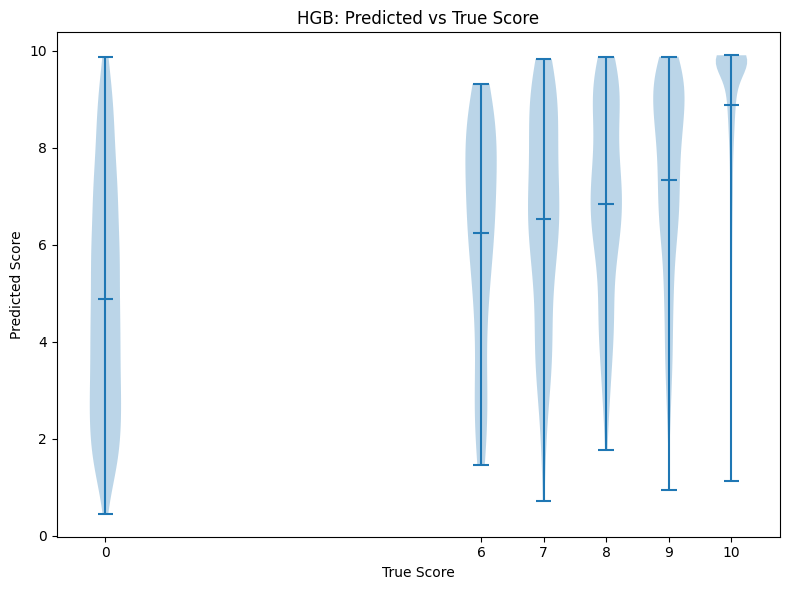

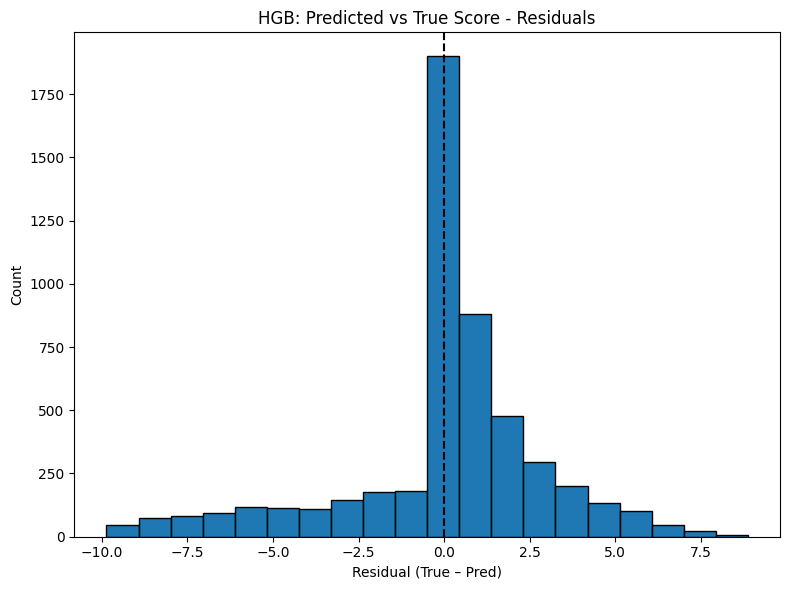

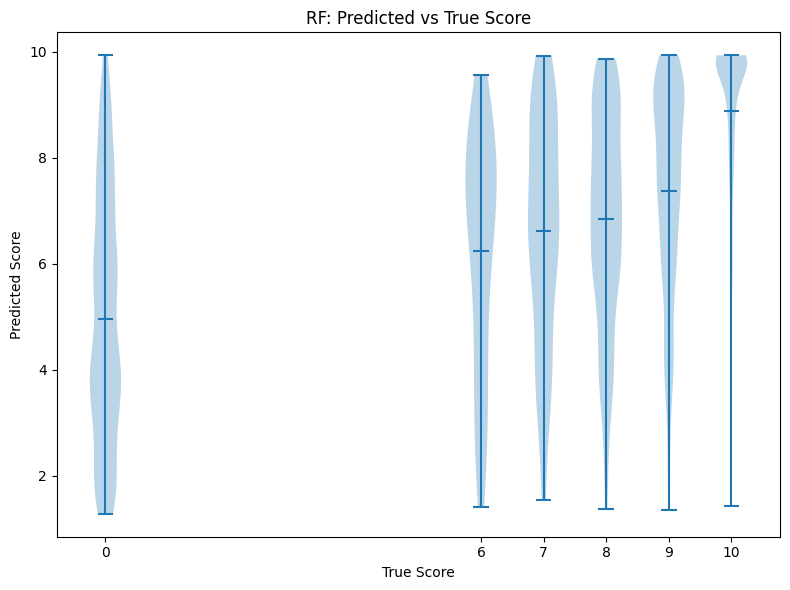

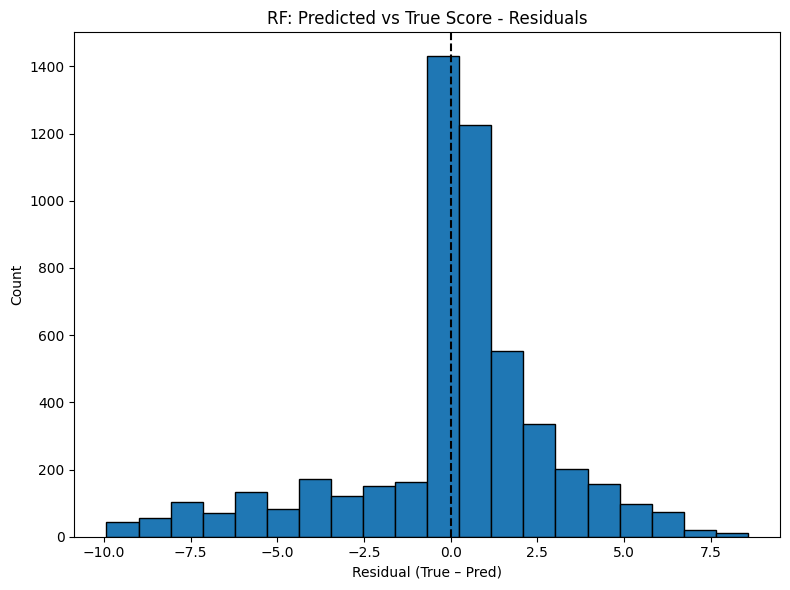

In [187]:
plot_predicted_violin(y_test, y_pred_hgb, title="HGB: Predicted vs True Score")
plot_predicted_violin(y_test, y_pred_rf,  title="RF: Predicted vs True Score")

Full finetuned

In [188]:
# results_finetuned.drop_duplicates(inplace=True)
# results_finetuned.head()

In [190]:
# Prepare data
X = results_finetuned[FEATURE_COLS].fillna(0)  # fill NaNs with 0
y = results_finetuned['score'].astype(float)  # ensure numeric

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(random_state=42)
hgb.fit(X_train, y_train)
y_pred_hgb = hgb.predict(X_test)

print("HistGradientBoostingRegressor")
print("  MAE: ", mean_absolute_error(y_test, y_pred_hgb))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_hgb)))

# RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandomForestRegressor")
print("  MAE: ", mean_absolute_error(y_test, y_pred_rf))
print("  RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

HistGradientBoostingRegressor
  MAE:  1.5163120418130025
  RMSE: 2.590296961096695

RandomForestRegressor
  MAE:  1.517233603649395
  RMSE: 2.5933805028949575


In [191]:
df_eval = X_test.copy()
df_eval['score_true']     = y_test
df_eval['score_pred_hgb'] = y_pred_hgb
df_eval['score_pred_rf']  = y_pred_rf

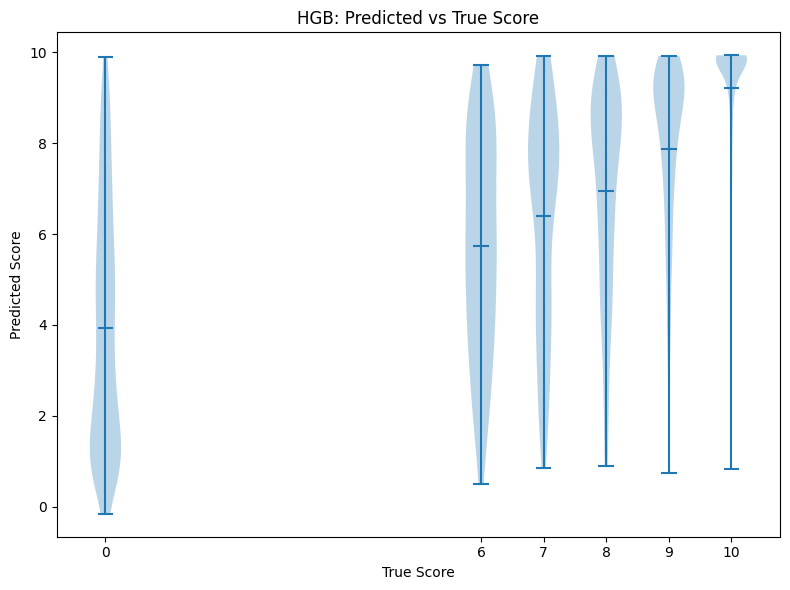

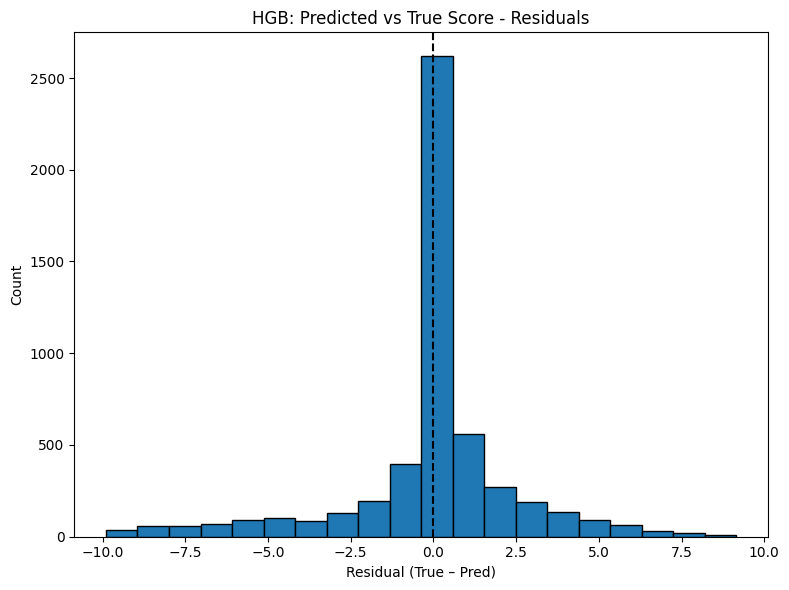

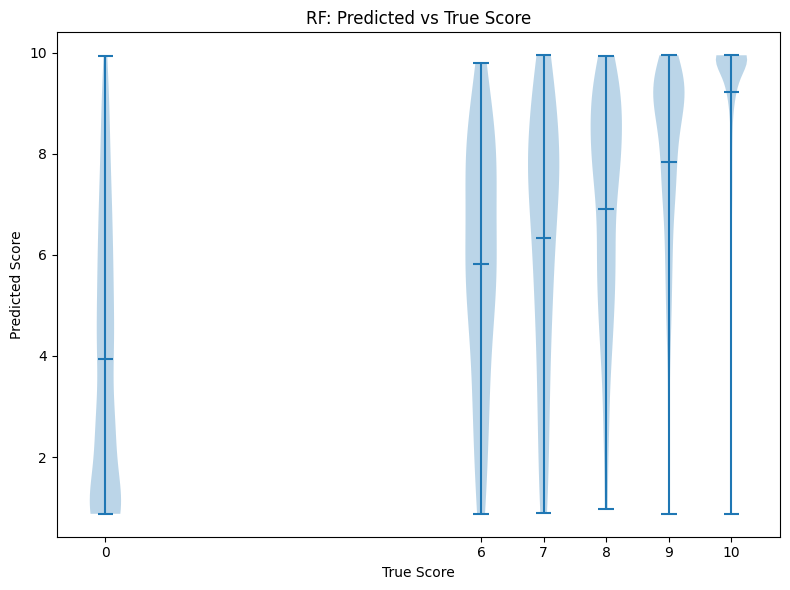

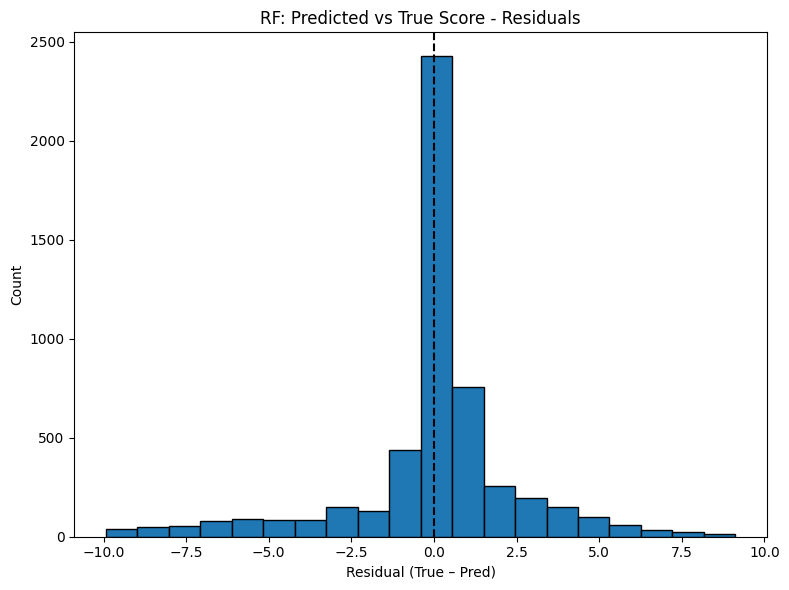

In [192]:
plot_predicted_violin(y_test, y_pred_hgb, title="HGB: Predicted vs True Score")
plot_predicted_violin(y_test, y_pred_rf,  title="RF: Predicted vs True Score")

Testing Full Fine-tune performance with score threshold

In [195]:
df_eval

,Proba Top1,Proba Top2,Proba Top3,Proba Top4,Proba Top5,cosine_sim_desc_vs_hs_text,prob_mean,prob_max,prob_min,prob_range,...,prob_diff_1_5,prob_diff_2_3,prob_diff_2_4,prob_diff_2_5,prob_diff_3_4,prob_diff_3_5,prob_diff_4_5,score_true,score_pred_hgb,score_pred_rf
224065,0.232240,0.105605,0.060820,0.060468,0.059412,0.000000,0.103709,0.232240,0.059412,0.172829,...,0.172829,0.044785,0.045137,0.046193,0.000352,0.001408,0.001056,0.0,2.919686,3.617408
35565,0.928334,0.034887,0.003721,0.003495,0.001524,0.652891,0.194392,0.928334,0.001524,0.926810,...,0.926810,0.031167,0.031392,0.033363,0.000226,0.002197,0.001971,10.0,9.791946,9.910824
96019,0.714530,0.243456,0.004515,0.003179,0.002318,0.000000,0.193600,0.714530,0.002318,0.712211,...,0.712211,0.238942,0.240278,0.241138,0.001336,0.002196,0.000860,10.0,9.216213,8.452533
202102,0.117768,0.086703,0.079635,0.062169,0.058973,0.349702,0.081049,0.117768,0.058973,0.058794,...,0.058794,0.007068,0.024534,0.027729,0.017466,0.020661,0.003195,0.0,1.149602,0.967759
225992,0.983581,0.004963,0.001836,0.001444,0.000703,0.615538,0.198505,0.983581,0.000703,0.982877,...,0.982877,0.003127,0.003519,0.004259,0.000393,0.001133,0.000740,10.0,9.808025,9.681319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235430,0.160753,0.130918,0.068036,0.059051,0.035763,0.545000,0.090904,0.160753,0.035763,0.124990,...,0.124990,0.062882,0.071867,0.095155,0.008985,0.032272,0.023287,6.0,3.469307,4.661839
167743,0.465258,0.418905,0.007868,0.007468,0.006557,0.616983,0.181211,0.465258,0.006557,0.458701,...,0.458701,0.411037,0.411437,0.412348,0.000400,0.001311,0.000911,10.0,8.822930,8.748247
253712,0.452235,0.133194,0.115302,0.050665,0.041316,0.552425,0.158542,0.452235,0.041316,0.410919,...,0.410919,0.017892,0.082529,0.091878,0.064637,0.073987,0.009350,0.0,4.291081,5.990934
227184,0.985222,0.005079,0.001865,0.000478,0.000353,0.840584,0.198599,0.985222,0.000353,0.984868,...,0.984868,0.003214,0.004601,0.004725,0.001387,0.001511,0.000124,10.0,9.923541,9.949091


Using score_pred_hgb to prevent wrong classifications

In [206]:
# accuracy without filters
100*len(df_eval.where(df_eval['score_true'] > 5).dropna())/len(df_eval)

82.13256484149856

In [222]:
# accuracy with score_pred_hgb > 4
df_eval_filtered = df_eval.where(df_eval['score_pred_hgb'] > 4).dropna()
100*len(df_eval_filtered.where(df_eval_filtered['score_true'] > 4).dropna())/len(df_eval_filtered)

90.6043228936921

In [223]:
# missing classifications %
100*(len(df_eval) - len(df_eval_filtered)) / len(df_eval)

12.891450528338137

In [ ]:
# missing classifications
len(df_eval) - len(df_eval_filtered)

671

In [228]:
# rejected classifications
rejected_clas = df_eval.where(df_eval['score_pred_hgb'] <= 4).dropna().sort_values(by='score_true', ascending=False)

In [233]:
df_rejected_clas = results_finetuned.loc[rejected_clas.index]

In [235]:
df_rejected_clas.where(df_rejected_clas['score'] > 5).dropna().sort_values(by='score', ascending=False)

,Description,True Label,Top1,Proba Top1,Top2,Proba Top2,Top3,Proba Top3,Top4,Proba Top4,...,prob_diff_2_5,prob_diff_3_4,prob_diff_3_5,prob_diff_4_5,score,top1_true,top2_true,top3_true,top4_true,top5_true
261626,2 IN 1 PLASTIC BLNDR & COFFEE GRINDER/1.5L 1X2,8509,8509,0.301907,8516,0.200578,3924,0.133744,3923,0.042565,...,0.166711,0.091180,0.099876,0.008697,10.0,1.0,1.0,1.0,1.0,1.0
11114,BATTREY,8507,8507,0.102120,8518,0.037239,8504,0.031107,8467,0.027567,...,0.010238,0.003540,0.004106,0.000565,10.0,1.0,1.0,1.0,1.0,1.0
155393,AIRCRAFT PARTS SPARE,8803,8803,0.969640,8707,0.004156,4012,0.001659,8411,0.001639,...,0.002535,0.000020,0.000038,0.000018,10.0,1.0,1.0,1.0,1.0,1.0
244682,USED BACK XCEL,8708,8708,0.107037,8711,0.099245,8504,0.060573,4202,0.038269,...,0.067586,0.022304,0.028914,0.006610,10.0,1.0,1.0,1.0,1.0,1.0
192475,MANHOLE COVER,7325,7325,0.376659,8716,0.066018,3925,0.062276,7308,0.057718,...,0.016949,0.004558,0.013206,0.008649,10.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256174,FESTO TUBE M12 - 5 MTR,8474,3917,0.082796,8708,0.056602,8421,0.055400,7307,0.045277,...,0.012985,0.010124,0.011783,0.001660,6.0,0.0,0.0,0.0,0.0,1.0
128651,CALAMINE POWDER BP,3003,2836,0.193398,2922,0.133114,2916,0.044702,2933,0.028196,...,0.107838,0.016506,0.019427,0.002921,6.0,0.0,0.0,0.0,0.0,1.0
146933,CLEARSPRING GREEN NORI FLAKES 20G,1104,1904,0.715073,2005,0.039035,2106,0.036874,2103,0.029689,...,0.010639,0.007185,0.008478,0.001293,6.0,0.0,0.0,0.0,0.0,1.0
255626,LASER MATTE OPAQUE,3920,3206,0.120761,9001,0.097674,3215,0.088003,3919,0.077889,...,0.040302,0.010114,0.030631,0.020517,6.0,0.0,0.0,0.0,0.0,1.0


___

## Conclusions

...
